In [1]:
from dataclasses import dataclass, asdict, field
import logging
from typing import Dict, List, Any
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import spotipy
from spotipy.oauth2 import SpotifyOAuth

In [2]:
@dataclass
class Track():
    """ Object class for representing a track on Spotify"""
    track_id: str
    track_uri: str
    track_name: str
    artist_name: str
    artist_id: str
    artist_uri: str
    popularity: str = field(default=None)
    duration_ms: float = field(default=None)

    def __str__(self):
        return f"{self.track_name} by {self.artist_name}"

In [3]:
def chunks(lst, chunk_size):
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

In [7]:
@dataclass
class SpotifyService():
    scope: str

    def __post_init__(self) -> None:
        self.spotifyClient = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=self.scope))
        self.saved_tracks = [*self.current_user_saved_tracks(), *self.current_user_saved_album_tracks(),
                             *self.current_user_recently_played()]

    def current_user_recently_played(self) -> List[Dict]:
        r = self.spotifyClient.current_user_recently_played(limit=50)
        saved_tracks = []
        for idx, item in enumerate(r['items']):
            track_dict = asdict(self._create_track(item))
            saved_tracks.append(track_dict)
        return saved_tracks
    
    def current_user_saved_tracks(self) -> List[Dict]:
        r = self.spotifyClient.current_user_saved_tracks(limit=50)
        saved_tracks = []
        for idx, item in enumerate(r['items']):
            track_dict = asdict(self._create_track(item))
            saved_tracks.append(track_dict)
        return saved_tracks
    
    def current_user_saved_album_tracks(self)-> Dict:
        r = self.spotifyClient.current_user_saved_albums(limit=50)
        saved_tracks = []
        for idx, album in enumerate(r['items']):
            detailed_track_json = [self.spotifyClient.track(i['uri']) for i in album['album']['tracks']['items']]
            album_tracks = [asdict(self._create_track({'track':track_resp})) for track_resp in detailed_track_json]
            saved_tracks = [*saved_tracks, *album_tracks]
        return saved_tracks
        
    def get_audio_analysis(self, limit=50, track_ids=None)-> Dict:
        if track_ids==None:
            track_ids = [track['track_uri'] for track in self.saved_tracks] 
            r = self.spotifyClient.audio_features(tracks=track_ids[:limit])
            saved_tracks_audio_analysis = saved_tracks_audio_analysis = dict(zip(track_ids, r))
        else:
            r = self.spotifyClient.audio_features(tracks=track_ids)
            saved_tracks_audio_analysis = dict(zip(track_ids, r))
        return saved_tracks_audio_analysis

    @staticmethod
    def _create_track(item):
        track = Track(track_id=item['track']['id'],
                      track_uri=item['track']['uri'],
                      track_name=item['track']['name'],
                      artist_id=item['track']['artists'][0]['id'],
                      artist_uri=item['track']['artists'][0]['uri'],
                      artist_name=item['track']['artists'][0]['name'],
                      popularity=item['track']['popularity'],
                      duration_ms=item['track']['duration_ms'])
        return track

In [8]:
ss = SpotifyService(scope='user-read-recently-played user-library-read')

In [9]:
ss.saved_tracks[0]

{'track_id': '4vYauy3ABO65vTXggGYaZg',
 'track_uri': 'spotify:track:4vYauy3ABO65vTXggGYaZg',
 'track_name': "Don't Leave Me This Way (feat. Teddy Pendergrass)",
 'artist_name': 'Harold Melvin & The Blue Notes',
 'artist_id': '438JBZR1AR0l04AzcYW9gy',
 'artist_uri': 'spotify:artist:438JBZR1AR0l04AzcYW9gy',
 'popularity': 63,
 'duration_ms': 363973}

In [10]:
len(ss.saved_tracks)

713

In [11]:
audio_analysis = ss.get_audio_analysis()

In [12]:
audio_analysis.popitem()

('spotify:track:4BAWCedKFfdwxPFmFv4DMG',
 {'danceability': 0.462,
  'energy': 0.427,
  'key': 9,
  'loudness': -13.333,
  'mode': 1,
  'speechiness': 0.0792,
  'acousticness': 0.893,
  'instrumentalness': 0.101,
  'liveness': 0.37,
  'valence': 0.476,
  'tempo': 101.675,
  'type': 'audio_features',
  'id': '4BAWCedKFfdwxPFmFv4DMG',
  'uri': 'spotify:track:4BAWCedKFfdwxPFmFv4DMG',
  'track_href': 'https://api.spotify.com/v1/tracks/4BAWCedKFfdwxPFmFv4DMG',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/4BAWCedKFfdwxPFmFv4DMG',
  'duration_ms': 159320,
  'time_signature': 3})

In [15]:
ss.spotifyClient.track('spotify:track:4BAWCedKFfdwxPFmFv4DMG')['name']

'Toothpaste Kisses'

In [16]:
def get_track_name(track_uri):
    return ss.spotifyClient.track(track_uri)['name']

In [17]:
audio_analysis_df = pd.DataFrame.from_dict(audio_analysis, orient='index')
audio_analysis_df['track_name'] = audio_analysis_df.index.map(get_track_name)
audio_analysis_df = audio_analysis_df.set_index('track_name')
audio_analysis_df.head(2)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
track_name,,,,,,,,,,,,,,,,,,
Don't Leave Me This Way (feat. Teddy Pendergrass),0.472,0.710,0,-8.852,1,0.0599,0.278000,0.000001,0.103,0.527,120.052,audio_features,4vYauy3ABO65vTXggGYaZg,spotify:track:4vYauy3ABO65vTXggGYaZg,https://api.spotify.com/v1/tracks/4vYauy3ABO65...,https://api.spotify.com/v1/audio-analysis/4vYa...,363973,4
To Lose My Life,0.542,0.818,10,-4.653,0,0.0318,0.000558,0.014100,0.126,0.290,132.048,audio_features,2hUHm19fmQnJ40LZXqjhZt,spotify:track:2hUHm19fmQnJ40LZXqjhZt,https://api.spotify.com/v1/tracks/2hUHm19fmQnJ...,https://api.spotify.com/v1/audio-analysis/2hUH...,191040,4


In [18]:
audio_analysis_df.describe(include='all')

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49,49,49,49,49,49.000000,49.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,49,49,49,49,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,audio_features,7bQJSXpmHUxQwnkoC0SYiS,spotify:track:4dsa8j4IOmhvoGzcgJg19r,https://api.spotify.com/v1/tracks/3KdoeNlEN0Bo...,https://api.spotify.com/v1/audio-analysis/4C0P...,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,1,1,1,1,NaN,NaN
mean,0.580469,0.679163,5.204082,-6.782429,0.755102,0.055878,0.230734,0.037490,0.159882,0.539606,121.645367,NaN,NaN,NaN,NaN,NaN,220483.367347,3.979592
std,0.129094,0.189820,3.576425,2.840324,0.434483,0.035225,0.260113,0.146318,0.102054,0.244196,29.588639,NaN,NaN,NaN,NaN,NaN,65100.904060,0.142857
min,0.308000,0.225000,0.000000,-13.150000,0.000000,0.026600,0.000088,0.000000,0.046500,0.078900,79.835000,NaN,NaN,NaN,NaN,NaN,130457.000000,3.000000
25%,0.502000,0.570000,2.000000,-8.852000,1.000000,0.032000,0.016100,0.000000,0.094400,0.354000,93.014000,NaN,NaN,NaN,NaN,NaN,184000.000000,4.000000
50%,0.588000,0.724000,5.000000,-6.431000,1.000000,0.045600,0.131000,0.000034,0.111000,0.542000,121.004000,NaN,NaN,NaN,NaN,NaN,202543.000000,4.000000
75%,0.674000,0.825000,8.000000,-4.623000,1.000000,0.062000,0.325000,0.007850,0.213000,0.742000,138.923000,NaN,NaN,NaN,NaN,NaN,233107.000000,4.000000


In [19]:
# most cheerful song (apparently)
audio_analysis_df['valence'].idxmax()

'Bang On The Gong'

In [20]:
AUDIO_FEATURES = ['danceability', 'energy', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

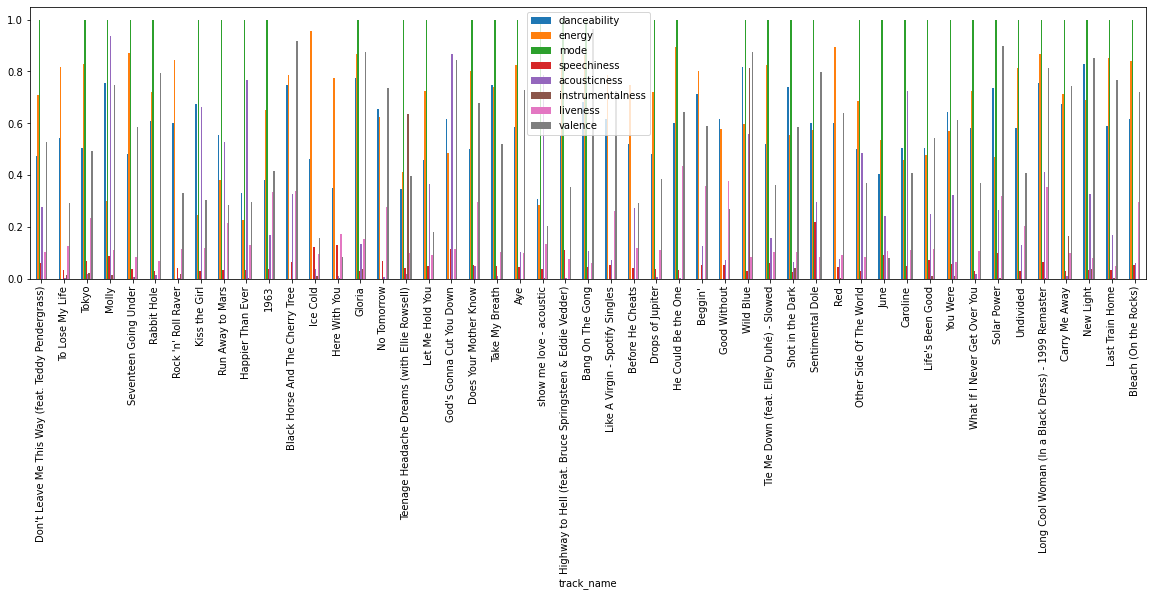

In [21]:
# leaving out tempo since that's on its own world
audio_analysis_df[AUDIO_FEATURES[:-1]].plot(kind='bar');

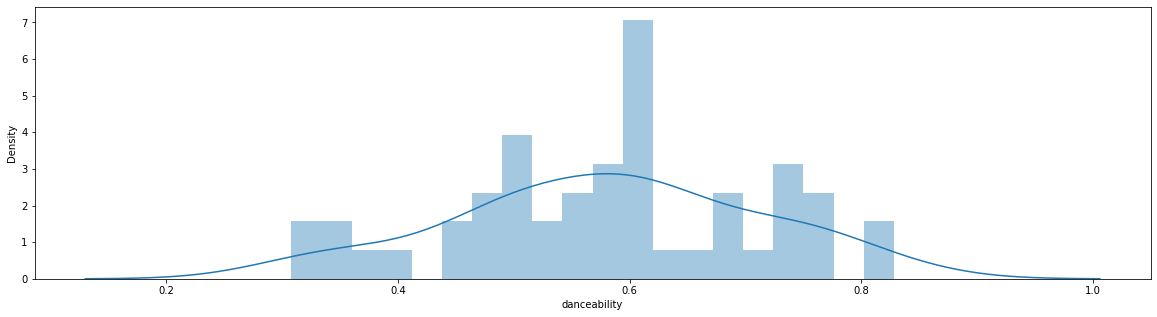

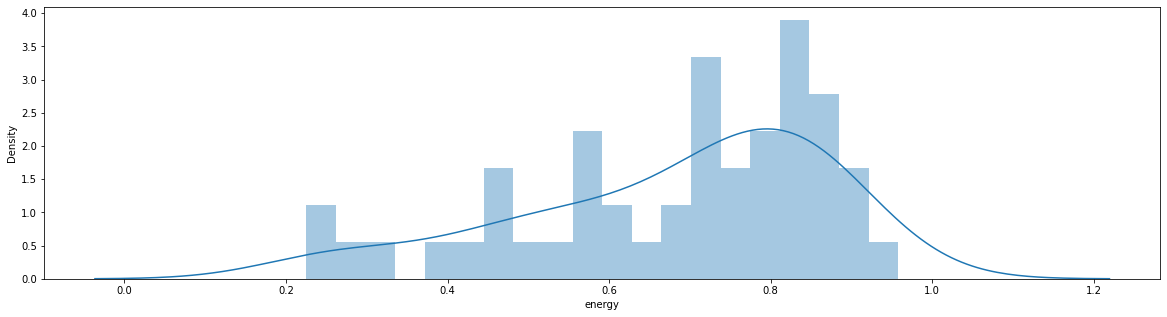

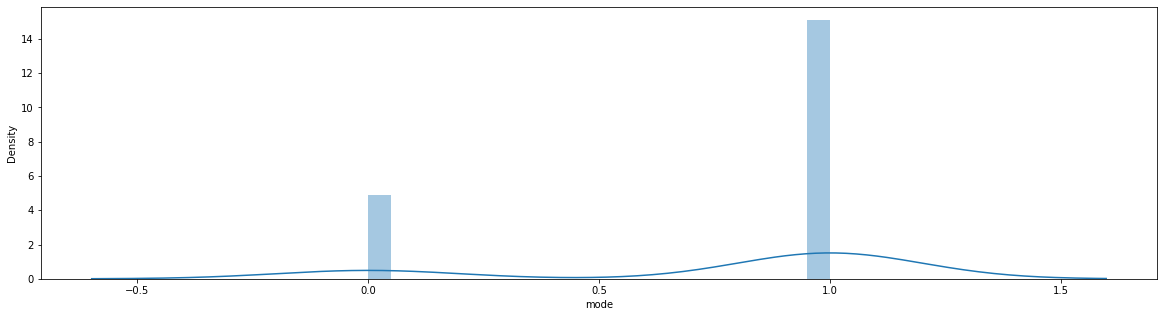

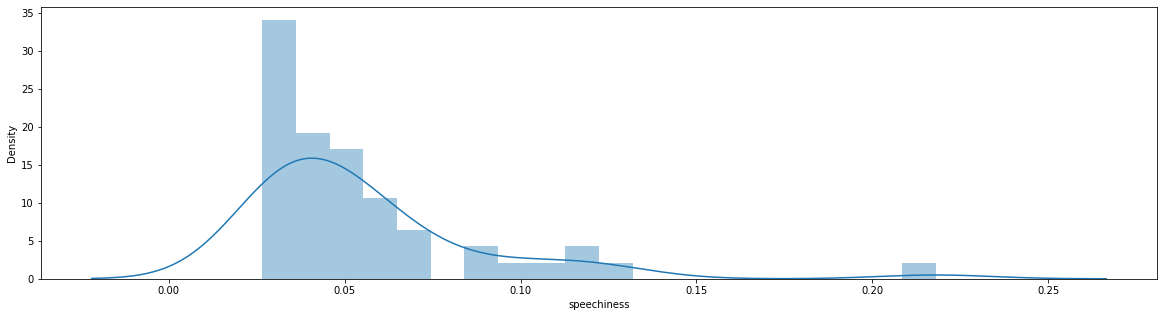

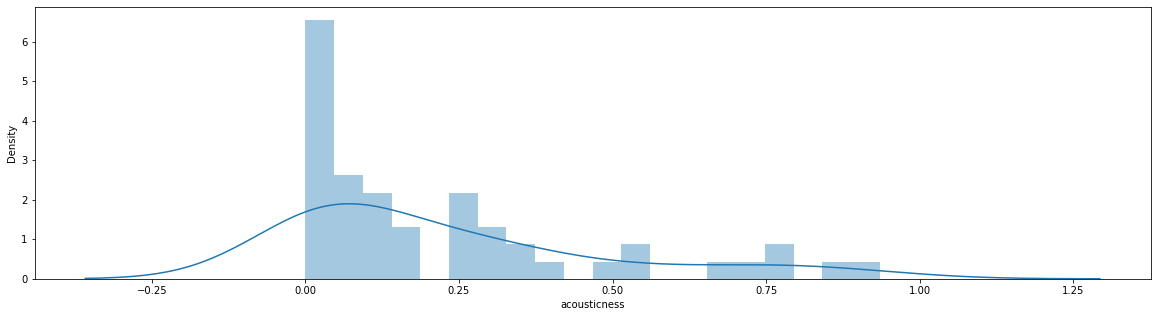

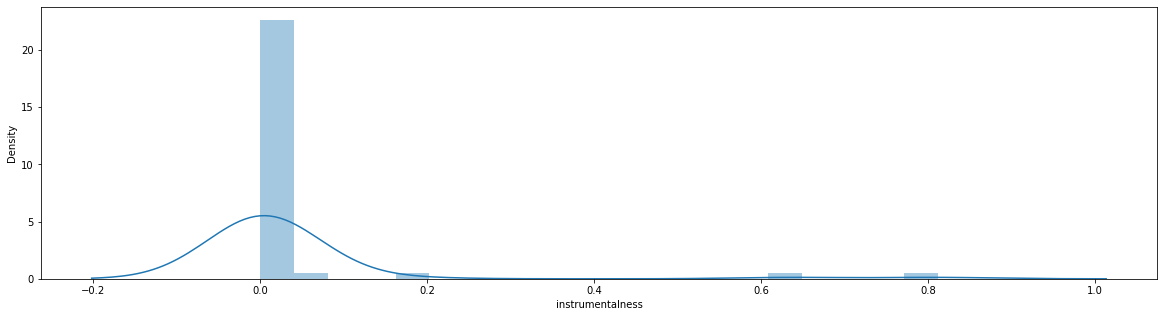

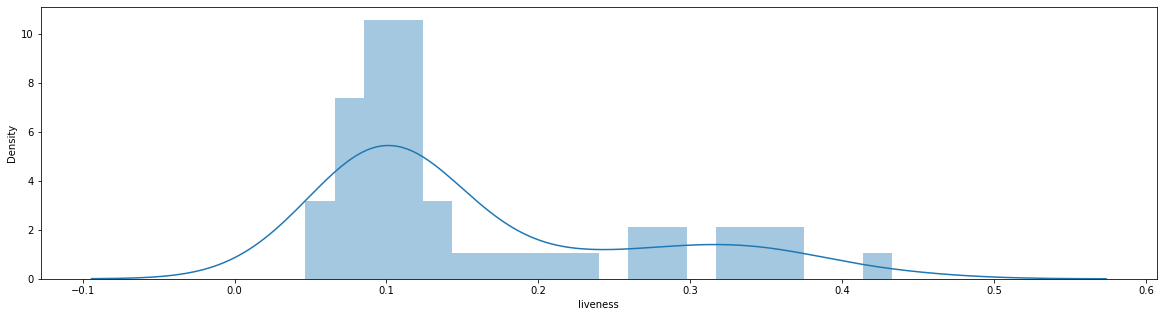

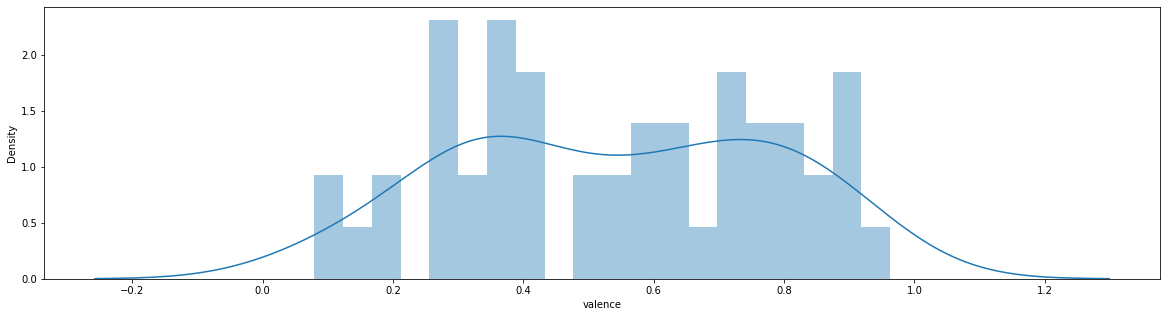

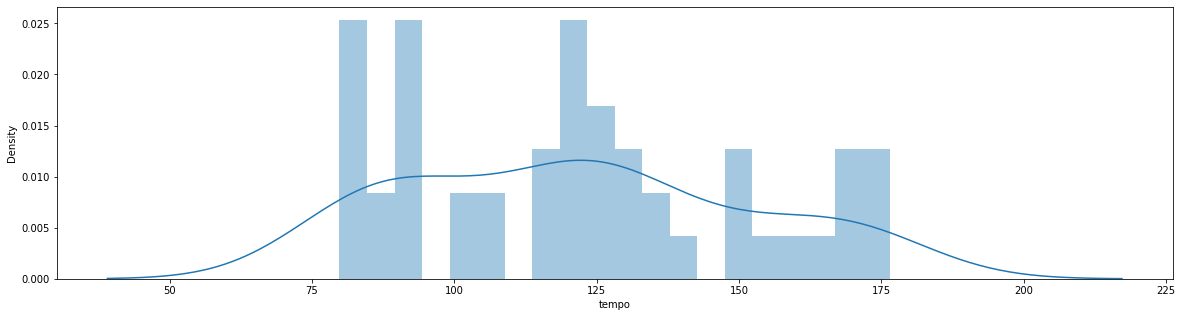

In [22]:
for feature in AUDIO_FEATURES:
    sns.distplot(audio_analysis_df[feature], hist=True, kde=True, bins=20);
    plt.show();

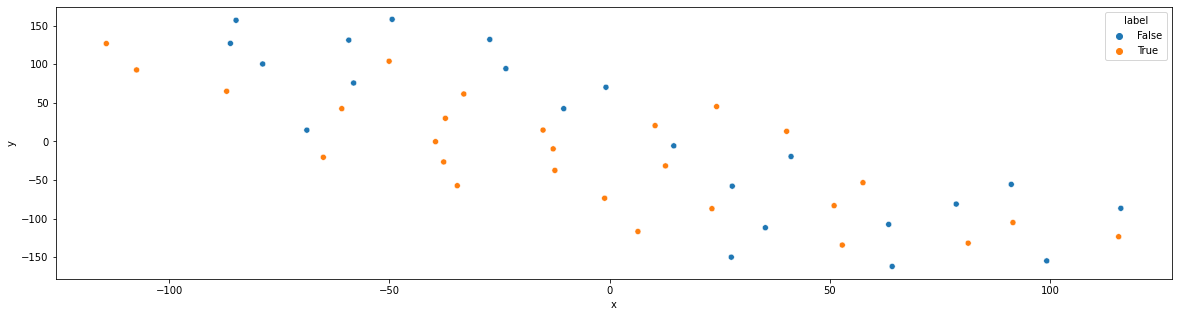

In [23]:
audio_analysis_df['y'] = audio_analysis_df['valence'] > 0.5

audio_tsne = TSNE(n_components=2).fit_transform(audio_analysis_df[AUDIO_FEATURES])

audio_tsne_df = pd.DataFrame(audio_tsne, columns=['x', 'y'])
audio_tsne_df['label'] = audio_analysis_df['y'].values

sns.scatterplot(x='x', y='y', hue='label', data=audio_tsne_df);

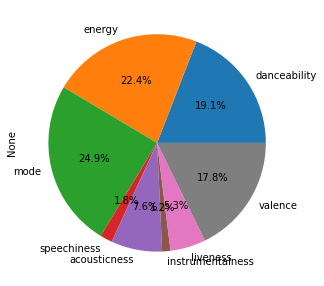

In [24]:
audio_analysis_df[AUDIO_FEATURES[:-1]].sum().plot.pie(autopct="%.1f%%");

In [25]:
# mode: 0=minor, 1=major
# valence = cheerfulness 